# **Analisis Clustering Tingkat Pengangguran Terbuka (TPT) Provinsi di Indonesia**

**Nama:** [Masukkan Nama Anda di Sini]  
**Dataset:** Tingkat Pengangguran Terbuka (TPT) menurut Provinsi (2021-2023)  
**Sumber:** Badan Pusat Statistik (BPS)  
**Tujuan:** Mengelompokkan provinsi di Indonesia berdasarkan pola tingkat pengangguran dari tahun 2021-2023 menggunakan algoritma K-Means.

---


## **1. Import Libraries**
Impor semua pustaka (library) Python yang dibutuhkan.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style='whitegrid', palette='viridis')
plt.style.use('seaborn-v0_8-talk')

print("✅ Library berhasil di-import!")

✅ Library berhasil di-import!


## **2. Data Loading & Understanding**

### **2.1. Memuat Dataset**

In [2]:
try:
    file_path = 'Tingkat Pengangguran Terbuka Berdasarkan Provinsi di Indonesia.csv'
    df_raw = pd.read_csv(file_path)
    print("✅ Dataset berhasil dimuat.")
    display(df_raw.head())
except FileNotFoundError:
    print("❌ File tidak ditemukan! Pastikan file sudah diunggah ke sesi Colab Anda.")

✅ Dataset berhasil dimuat.


,id,kode_provinsi,nama_provinsi,indeks_tpt,satuan,tahun
0,1,11,ACEH,6.34,PERSEN,2018
1,2,12,SUMATERA UTARA,5.55,PERSEN,2018
2,3,13,SUMATERA BARAT,5.66,PERSEN,2018
3,4,14,RIAU,5.98,PERSEN,2018
4,5,15,JAMBI,3.73,PERSEN,2018


### **2.2. Informasi Dasar Dataset**

In [3]:
print("\nInformasi Dasar Dataset:")
df_raw.info()
print("\nKolom:", df_raw.columns.tolist())


Informasi Dasar Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             242 non-null    int64  
 1   kode_provinsi  242 non-null    int64  
 2   nama_provinsi  242 non-null    object 
 3   indeks_tpt     242 non-null    float64
 4   satuan         242 non-null    object 
 5   tahun          242 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 11.5+ KB

Kolom: ['id', 'kode_provinsi', 'nama_provinsi', 'indeks_tpt', 'satuan', 'tahun']


> **Observasi:** Kolom `tingkat_pengangguran_terbuka` terdeteksi sebagai `object` karena penggunaan koma sebagai desimal. Ini perlu diperbaiki.

---

## **3. Data Preprocessing**

### **3.1. Membersihkan dan Menyesuaikan Data**

In [4]:
# Normalisasi nama kolom
df = df_raw.copy()
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Pastikan kolom 'indeks_tpt' ada
if 'indeks_tpt' in df.columns:
    df['indeks_tpt'] = df['indeks_tpt'].astype(float)
else:
    raise KeyError("Kolom 'indeks_tpt' tidak ditemukan dalam dataset.")

# Drop kolom tidak relevan
df = df.drop(columns=['id', 'kode_provinsi', 'satuan'])

print("✅ Kolom berhasil dibersihkan dan disiapkan.")
df.info()

✅ Kolom berhasil dibersihkan dan disiapkan.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   nama_provinsi  242 non-null    object 
 1   indeks_tpt     242 non-null    float64
 2   tahun          242 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 5.8+ KB


### **3.2. Pivot Tabel**

In [5]:
# Pivot data menjadi format per provinsi per tahun
df_pivot = df.pivot_table(index='nama_provinsi', columns='tahun', values='indeks_tpt').reset_index()
df_pivot.columns.name = None
df_pivot = df_pivot.rename(columns={2021: 'tpt_2021', 2022: 'tpt_2022', 2023: 'tpt_2023'})

print("\n✅ Data berhasil di-pivot. Struktur data baru:")
display(df_pivot.head())


✅ Data berhasil di-pivot. Struktur data baru:


,nama_provinsi,2018,2019,2020,tpt_2021,tpt_2022,tpt_2023,2024
0,ACEH,6.34,6.17,6.59,6.30,6.17,6.03,5.75
1,BALI,1.40,1.57,5.63,5.37,4.80,2.69,1.79
2,BANTEN,8.47,8.11,10.64,8.98,8.09,7.52,6.68
3,BENGKULU,3.35,3.26,4.07,3.65,3.59,3.42,3.11
4,DI YOGYAKARTA,3.37,3.18,4.57,4.56,4.06,3.69,3.48


## **4. Exploratory Data Analysis (EDA)**

### **4.1. Distribusi TPT per Tahun**

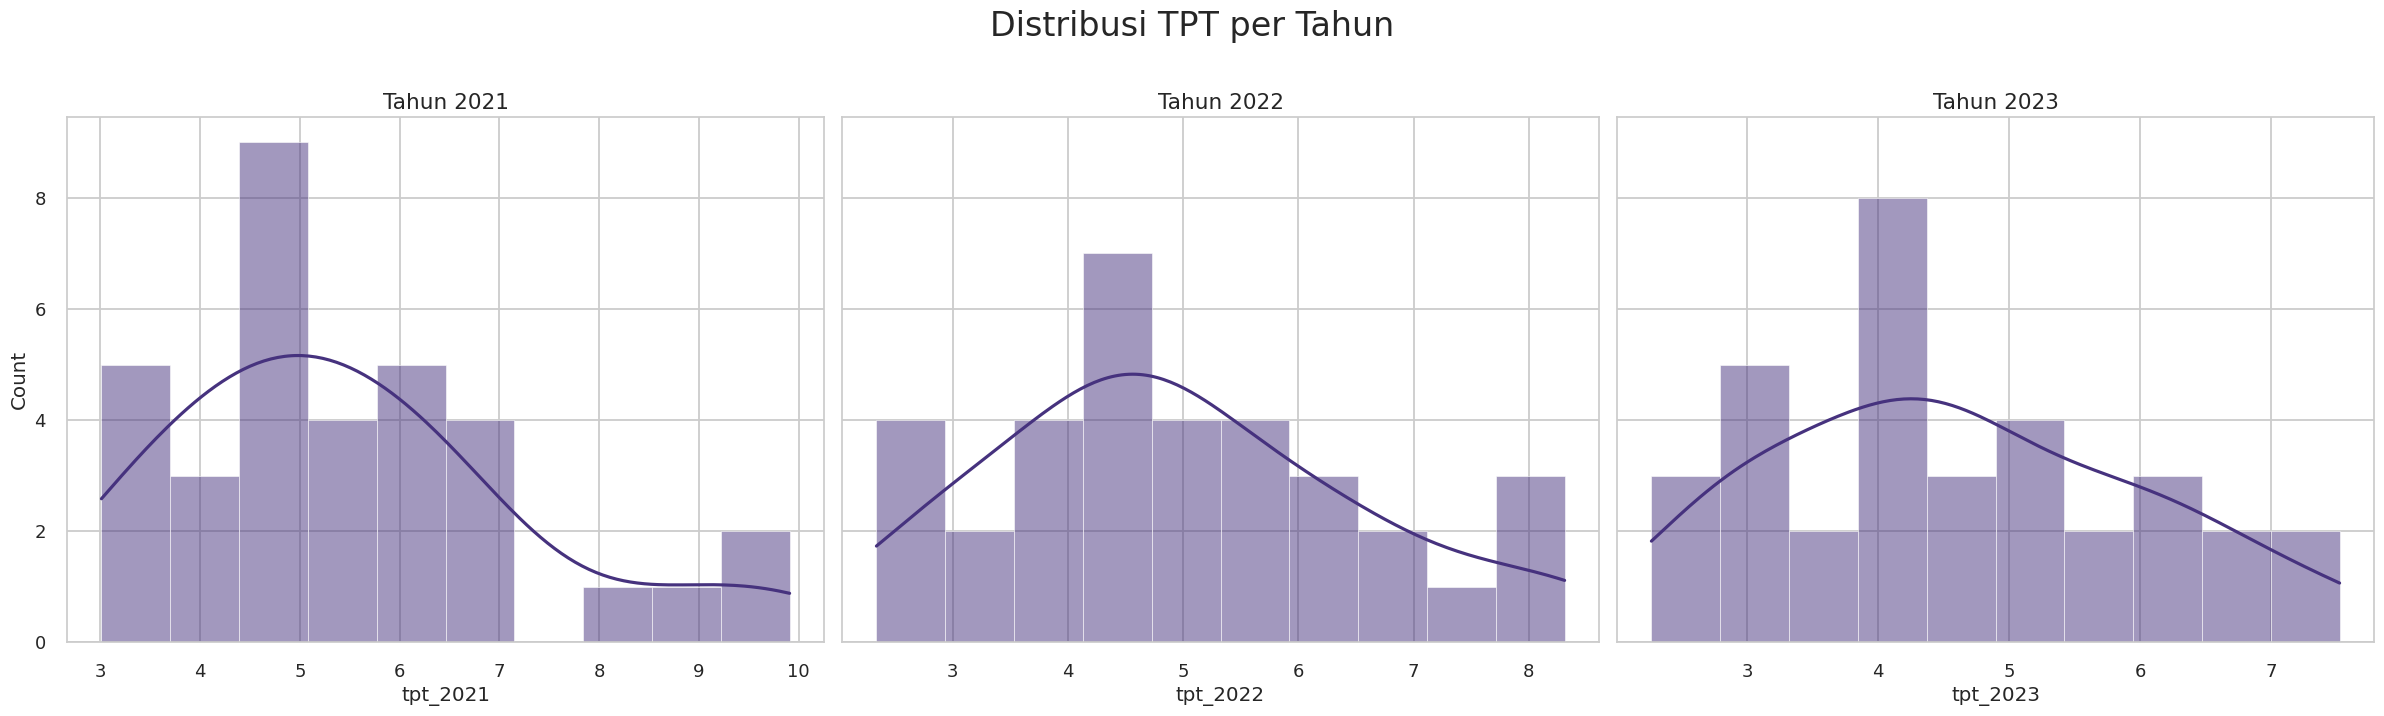

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
fig.suptitle('Distribusi TPT per Tahun', fontsize=24, y=1.02)
sns.histplot(ax=axes[0], data=df_pivot, x='tpt_2021', kde=True, bins=10).set_title('Tahun 2021')
sns.histplot(ax=axes[1], data=df_pivot, x='tpt_2022', kde=True, bins=10).set_title('Tahun 2022')
sns.histplot(ax=axes[2], data=df_pivot, x='tpt_2023', kde=True, bins=10).set_title('Tahun 2023')
plt.tight_layout()
plt.show()

> **Observasi:** Distribusi di ketiga tahun cenderung *right-skewed*.

## **5. Modeling (K-Means Clustering)**

### **5.1. Feature Scaling**

In [7]:
print(df_pivot.isnull().sum())

nama_provinsi    0
2018             4
2019             4
2020             4
tpt_2021         4
tpt_2022         4
tpt_2023         4
2024             0
dtype: int64


In [8]:
df_pivot = df_pivot.dropna()

In [9]:
features = df_pivot[['tpt_2021', 'tpt_2022', 'tpt_2023']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print("✅ Fitur berhasil di-scaling.")

✅ Fitur berhasil di-scaling.


### **5.2. Elbow Method untuk Menentukan k**

In [10]:
features = df_pivot[['tpt_2021', 'tpt_2022', 'tpt_2023']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


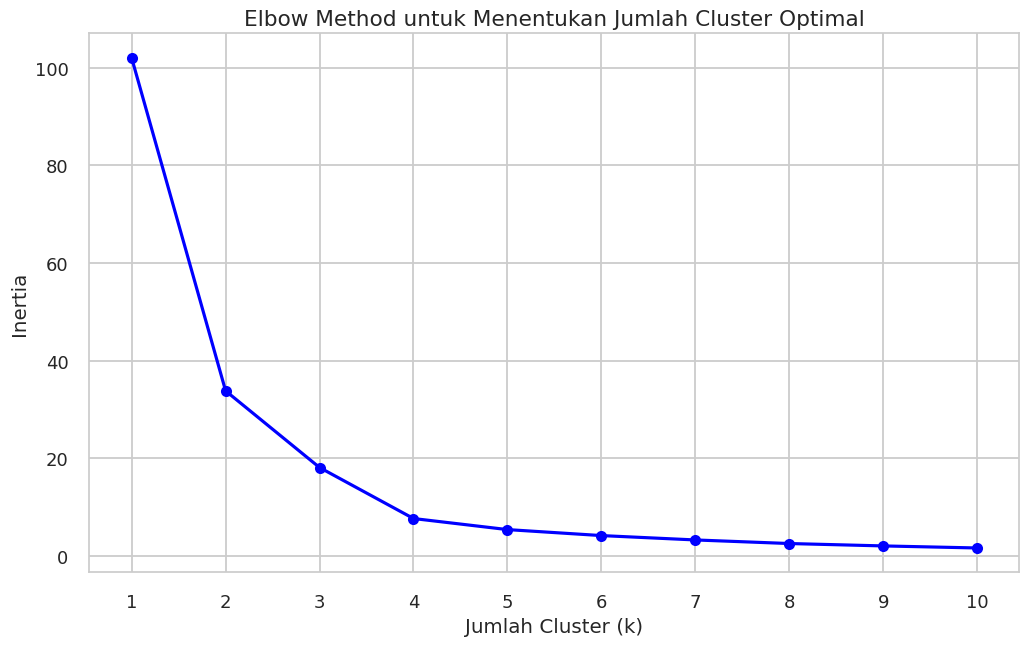

In [11]:
# Inisialisasi list untuk menyimpan nilai inertia
inertia = []

# Range jumlah cluster yang akan diuji
K = range(1, 11)

# Loop untuk menghitung inertia tiap jumlah cluster
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Visualisasi elbow plot
plt.figure(figsize=(12, 7))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.grid(True)
plt.xticks(K)
plt.show()

> **Observasi:** Titik siku terlihat di **k=2**.

### **5.3. Pelatihan Model K-Means**

In [20]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(features_scaled)
df_pivot['cluster'] = kmeans.labels_
print(f"✅ Model K-Means dengan {optimal_k} cluster berhasil dilatih.")

✅ Model K-Means dengan 2 cluster berhasil dilatih.


## **6. Evaluation & Analysis**

### **6.1. Karakteristik Cluster**

In [21]:
cluster_profile = df_pivot.groupby('cluster')[['tpt_2021', 'tpt_2022', 'tpt_2023']].mean()
display(cluster_profile)

,tpt_2021,tpt_2022,tpt_2023
cluster,,,
0,7.180714,6.511429,6.022143
1,4.310000,3.884500,3.628000


> **Interpretasi:**
> - Cluster 0: Kelompok Daerah dengan TPT Tinggi
> - Cluster 1: Kelompok Daerah dengan TPT Rendah

### **6.2. Visualisasi PCA**

,tpt_2021,tpt_2022,tpt_2023
cluster,,,
0,7.180714,6.511429,6.022143
1,4.310000,3.884500,3.628000


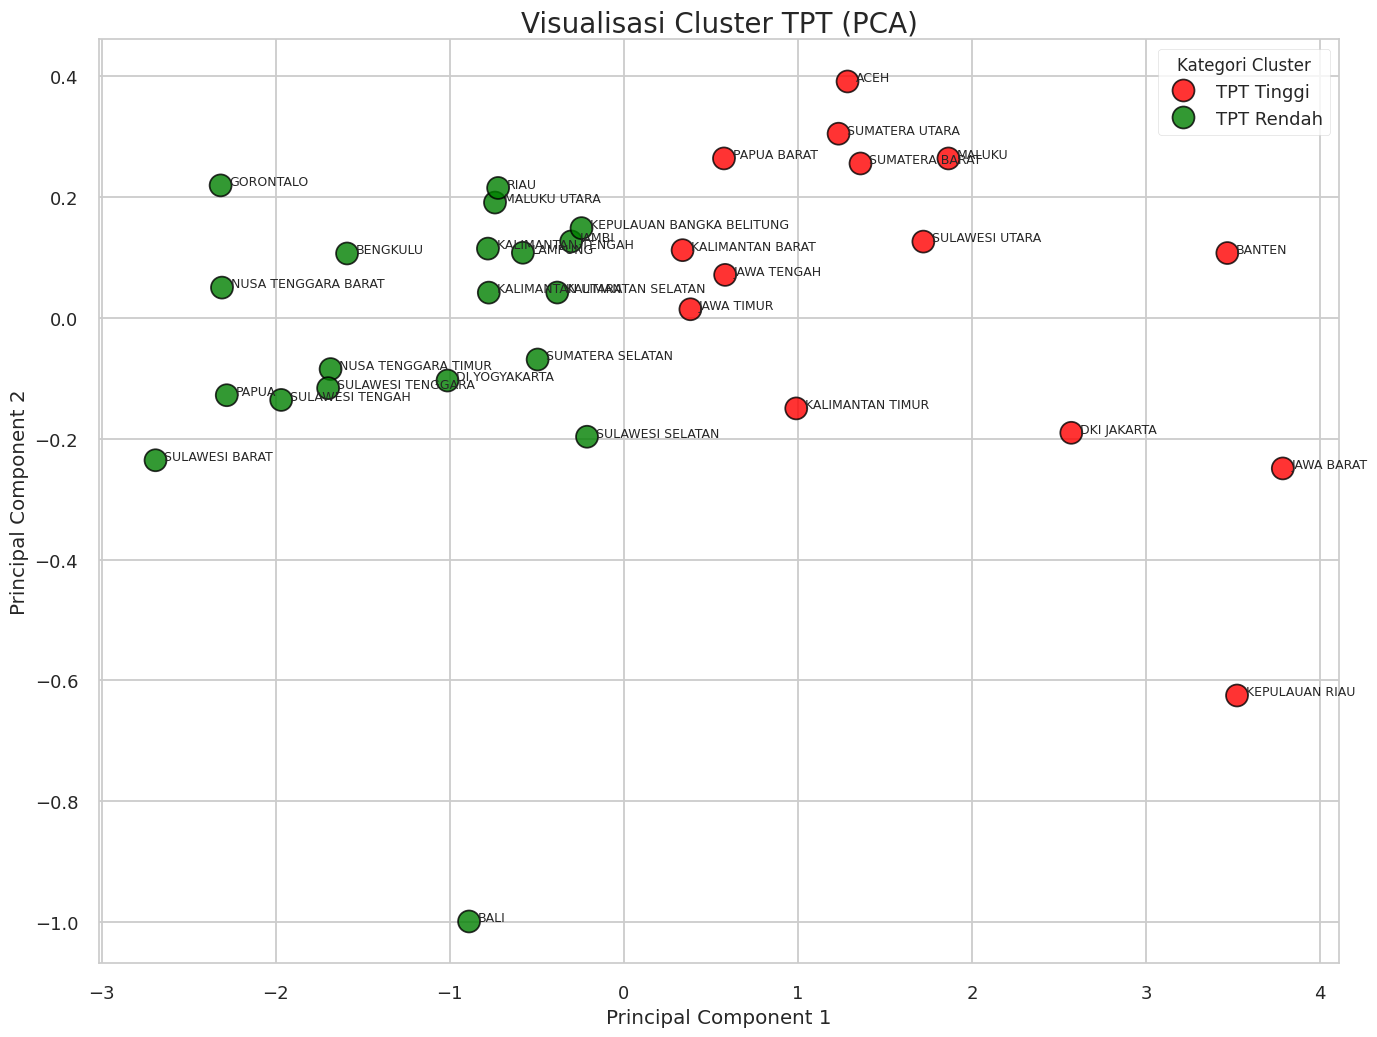

In [24]:
# 6.2. Visualisasi Hasil Cluster (dengan PCA)
# Hitung profil cluster berdasarkan rata-rata TPT
cluster_profile = df_pivot.groupby('cluster')[['tpt_2021', 'tpt_2022', 'tpt_2023']].mean()
display(cluster_profile)

# Mapping dua cluster: TPT Rendah dan TPT Tinggi
cluster_map = {
    cluster_profile.mean(axis=1).idxmin(): 'TPT Rendah',
    cluster_profile.mean(axis=1).idxmax(): 'TPT Tinggi'
}
df_pivot['nama_cluster'] = df_pivot['cluster'].map(cluster_map)

# Visualisasi hasil cluster dalam 2D PCA
plt.figure(figsize=(16, 12))
sns.scatterplot(
    data=df_pivot,
    x='pca1',
    y='pca2',
    hue='nama_cluster',
    palette={'TPT Rendah': 'green', 'TPT Tinggi': 'red'},
    s=250,
    alpha=0.8,
    edgecolor='k'
)

# Tambahkan label nama provinsi (BAGIAN YANG DIPERBAIKI)
for index, row in df_pivot.iterrows():
    plt.text(row['pca1'] + 0.05, row['pca2'], row['nama_provinsi'], fontsize=9)

plt.title('Visualisasi Cluster TPT (PCA)', fontsize=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Kategori Cluster')
plt.grid(True)
plt.show()

### **6.3. Daftar Provinsi per Cluster**

In [25]:
for name, group in df_pivot.groupby('nama_cluster'):
    print(f"--- Cluster: {name} ({len(group)} Provinsi) ---")
    print(", ".join(group['nama_provinsi'].tolist()))
    print("\n")

--- Cluster: TPT Rendah (20 Provinsi) ---
BALI, BENGKULU, DI YOGYAKARTA, GORONTALO, JAMBI, KALIMANTAN SELATAN, KALIMANTAN TENGAH, KALIMANTAN UTARA, KEPULAUAN BANGKA BELITUNG, LAMPUNG, MALUKU UTARA, NUSA TENGGARA BARAT, NUSA TENGGARA TIMUR, PAPUA, RIAU, SULAWESI BARAT, SULAWESI SELATAN, SULAWESI TENGAH, SULAWESI TENGGARA, SUMATERA SELATAN


--- Cluster: TPT Tinggi (14 Provinsi) ---
ACEH, BANTEN, DKI JAKARTA, JAWA BARAT, JAWA TENGAH, JAWA TIMUR, KALIMANTAN BARAT, KALIMANTAN TIMUR, KEPULAUAN RIAU, MALUKU, PAPUA BARAT, SULAWESI UTARA, SUMATERA BARAT, SUMATERA UTARA




## 7. Kesimpulan

Berdasarkan analisis clustering yang telah dilakukan terhadap data Tingkat Pengangguran Terbuka (TPT) di 34 provinsi Indonesia dari tahun 2021 hingga 2023, dapat ditarik beberapa kesimpulan utama:

1.  **Penentuan Jumlah Cluster Optimal:** Dengan menggunakan **Metode Siku (Elbow Method)**, ditemukan bahwa jumlah cluster yang paling optimal untuk mengelompokkan provinsi-provinsi ini adalah **2 cluster**. Titik siku pada grafik menunjukkan bahwa setelah 2 cluster, penambahan jumlah cluster baru tidak lagi memberikan penurunan *inertia* yang signifikan.

2.  **Karakteristik Cluster:** Model K-Means berhasil membagi provinsi ke dalam dua kelompok yang berbeda secara karakteristik TPT-nya:
    * **Cluster TPT Tinggi (14 Provinsi):** Kelompok ini diisi oleh provinsi-provinsi dengan rata-rata TPT yang secara konsisten lebih tinggi, berkisar antara **6.0% hingga 7.2%** selama periode 2021-2023. Provinsi yang termasuk di dalamnya antara lain adalah **DKI Jakarta, Jawa Barat, Banten, Kepulauan Riau, dan Sumatera Utara**.
    * **Cluster TPT Rendah (20 Provinsi):** Kelompok ini menunjukkan rata-rata TPT yang lebih rendah dan cenderung stabil, di angka **3.6% hingga 4.3%**. Provinsi seperti **Bali, DI Yogyakarta, Bengkulu, dan sebagian besar di Kalimantan serta Sulawesi** masuk ke dalam cluster ini.

3.  **Wawasan (Insight):** Pengelompokan ini menunjukkan adanya polarisasi kondisi pasar tenaga kerja di Indonesia. Menariknya, cluster dengan TPT yang lebih tinggi banyak diisi oleh provinsi yang merupakan pusat industri dan urbanisasi. Hal ini dapat mengindikasikan tantangan pengangguran di perkotaan (*urban unemployment*) yang lebih besar dibandingkan dengan daerah lain yang mungkin ekonominya lebih bertumpu pada sektor agraris atau pariwisata.

Analisis ini dapat menjadi dasar bagi pembuat kebijakan untuk merancang intervensi yang lebih terfokus sesuai dengan karakteristik TPT di masing-masing kelompok provinsi.